# OFDM Transmitter and Receiver

Authored by Meles Gebreyesus Weldegebriel and Neal Patwari, 2025.

This code is in three sections:
1. Generates an OFDM packet for transmission over SDRs (using UHD drivers for control).
2. The packet can then be transmitted over the air in POWDER using Shout using the given instructions.
3. The received packet data can then be loaded here for the OFDM Receiver, which demodulates the OFDM packet.

### TODAY'S LAB (22 Sept 2025)

In today's lab, we're going to run only the receiver. You should run all of the TX and OTA experiment blocks to be familiar with them (and to import all packages and define all needed functions), but no modification of the TX code is needed, and no OTA experiment will be run in today's lab. Of course, feel free to use the code to do your project... there are quite a few extensions that could be done to make this OFDM TX & RX better.

For the receiver, we use the stop sign emoji (🛑) to show you particular parts that you will need to implement code in. Look for these as you progress.

🛑 First, in this google colab, you'll need to upload the file "preamble.mat" and "10dB_rx_output.mat". These files are in the [github repo](https://github.com/npatwari/OFDM_TX_RX_Lab). You upload a file by clicking on the folder icon, then clicking on the paper with an up arrow icon.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal as signal
from itertools import chain
from scipy.signal import correlate, correlation_lags, fftconvolve

## 1. OFDM Transmitter

Start by defining some functions used throughout the lab.

In [12]:
# Routine digital comms functions

def text2bits(message):
    # Convert text message to list of bits (ASCII 8-bit binary per character)
    return [int(bit) for char in message for bit in format(ord(char), '07b')]

def lut(data, inputVec, outputVec):
    # Lookup table for modulation mapping
    output = np.zeros(data.shape)
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        for k in range(len(data)):
            if abs(data[k] - inputVec[i]) < eps:
                output[k] = outputVec[i]
    return output

def binary2mary(data, M):
    # Convert binary data to M-ary symbols
    log2M = round(math.log2(M))
    if len(data) % log2M != 0:
        raise ValueError("Input to binary2mary must be divisible by log2(M).")
    binvalues = 2 ** np.arange(log2M - 1, -1, -1)
    reshaped_data = np.reshape(data, (-1, log2M))
    return reshaped_data.dot(binvalues)



This is where the user can edit the OFDM parameters. For example, the FFT size, the cyclic prefix (CP) size, the number of pilot and guard band subcarriers and the pilot value. The message is a user-defined text string, converted to 7 bits per character. The 2nd code block below is for displaying the choice of subcarriers to the user.

In [13]:
# Basic OFDM and system parameters
FFT_size = 64  # Number of FFT points
OFDM_size = 80  # Total size including cyclic prefix
data_size = 48  # Number of data subcarriers
mess_length = 560
CP = 16  # Cyclic prefix length
pilotValue = 2* (1.4142 + 1.4142j)  # Pilot symbol

# **Text message to encode**
# We need len(text_message)*7 to be divisible by data_size*2.
# Mostly this means that the text message should be data_size*2 characters long
#text_message = 'Pseudonymetry: A new spectrum sharing protocol for cooperative coexistence b/n wireless systems.'
text_message = 'Orthogonal frequency division multiplexing has subcarrier spacing of one half of the symbol rate'
print('Message length:', len(text_message), 'characters')

# Subcarrier allocations made by you, the user
pilotCarriers = np.array([-21,-7,7,21])  # Pilot carriers
dataCarriers = np.array([-26,-25,-24,-23,-22,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,
                              -9,-8,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,
                              18,19,20,22,23,24,25,26])

allCarriers = np.arange(-FFT_size//2, FFT_size//2)
reserved = np.concatenate((dataCarriers, pilotCarriers))
guardCarriers = np.array([sc for sc in allCarriers if sc not in reserved])
print('Number of carriers:', len(allCarriers))
print('Number of pilot carriers:', len(pilotCarriers))
print('Number of data carriers:', len(dataCarriers))
print('Number of guard carriers:', len(guardCarriers))


Message length: 96 characters
Number of carriers: 64
Number of pilot carriers: 4
Number of data carriers: 48
Number of guard carriers: 12


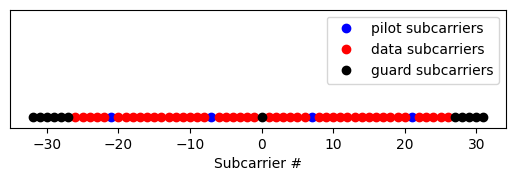

In [14]:
# Plot a (1-D) view of the subcarriers, showing guard bands, pilots, and data subcarriers.
plt.figure()
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot subcarriers')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data subcarriers')
plt.plot(guardCarriers, np.zeros_like(guardCarriers), 'ko', label='guard subcarriers')
plt.xlabel("Subcarrier #")
plt.gca().set_aspect(aspect=150) # doesn't need to be tall
plt.ylim(-0.01, 0.1)
plt.yticks([]) # avoid the impression we're plotting something on the y-axis
plt.legend()

In [15]:
def QPSK_symbol_values(message):
    # Generate modulated data symbols using QPSK
    A = math.sqrt(9/2)  # Amplitude scaling
    data_sequence = text2bits(message)  # Convert message to bits
    # data_bits = np.tile(data_sequence, 20)  # Repeat bits to fill frame
    data_sequence = np.tile(data_sequence,10)
    data = binary2mary(data_sequence, 4)  # Convert to 4-ary symbols (QPSK)

    # QPSK mapping
    inputVec = [0, 1, 2, 3]
    outputVecI = [A, -A, A, -A]
    outputVecQ = [A, A, -A, -A]

    # Map symbols to complex IQ samples
    xI = lut(data, inputVec, outputVecI).reshape((1, len(data)))
    xQ = lut(data, inputVec, outputVecQ).reshape((1, len(data)))
    qpsk_IQ = (xI.flatten() + 1j*xQ.flatten()).astype(np.complex64)
    return qpsk_IQ


This function assembles each OFDM symbol in the frequency domain:

*   `Symbol`: The `FFT_size` length vector that represents the OFDM symbol in the frequency domain, one value for each subcarrier. It is initialized to all zeros.
*   `Payload` are the `data_size` QPSK symbol values that are to be copied into the Symbol vector, but into the specific `dataCarriers` indices. One QPSK symbol for each dataCarriers index.
*   `pilotValue` is the constant complex value to be put into every pilot subcarrier, as listed in the `pilotCarriers` vector.
*   You don't need to do anything for the guard band subcarriers, because they should be zero, and `Symbol` was initialized to zeros.

Finally, we use numpy's IFFT command `np.fft.ifft` to calculate the `FFT_size` inverse fast Fourier transform of the `Symbol` vector. We call the output `ofdm_time`.


In [16]:
def generate_ofdm_signal(data):
    # Initialize the entire OFDM signal (of many symbols)
    result = []

    # For each symbol. The symbol can contain `data_size` symbol values.
    for i in range(len(data) // data_size):

        # Which data symbol values should this symbol contain?
        Payload = data[i * data_size: (i + 1) * data_size]

        # Initialize the subcarrier values to zero.
        Symbol = np.zeros(FFT_size, dtype=complex)

        # Insert pilot symbols. The pilotValue should be put in each subcarrier.
        Symbol[pilotCarriers] = pilotValue ### YOUR CODE HERE ###

        # Insert data symbols. The Payload (length data_size) values should be
        # copied into the dataCarriers (length data_size)
        Symbol[dataCarriers] = Payload ### YOUR CODE HERE ###

        # Do the IFFT to convert Symbol to the time domain.
        ofdm_time = np.fft.ifft(Symbol, n=FFT_size) ### YOUR CODE HERE ###

        # Prepend the cyclic prefix, ie, the last CP samples in the time-domain
        # to the start of the time domain signal.
        cp = ofdm_time[-CP:]
        result.extend(np.hstack([cp, ofdm_time]))

        # Plot the OFDM packet in the frequency domain and time domain.
        # Do this only for the first symbol, otherwise it'll produce too many
        if i==0:
            plt.figure(3)
            subcarrier_nums = list(range(FFT_size//2)) + list(range(-(FFT_size//2),0))
            print(len(subcarrier_nums))
            plt.plot(subcarrier_nums, np.real(Symbol),'k.', label="real(Symbol)")
            plt.plot(subcarrier_nums, np.imag(Symbol),'r.', label="imag(Symbol)")
            plt.xlabel('Subcarrier #')
            plt.ylabel('Value')
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.75), ncol=2)
            plt.grid(True)
            plt.figure(4)
            plt.plot(range(0, FFT_size), np.real(ofdm_time),'k.', label="real(time signal)")
            plt.plot(range(0, FFT_size), np.imag(ofdm_time),'r.', label="imag(time signal)")
            plt.plot(range(-CP, 0), np.real(cp),'b.', label="real(cyclic prefix)")
            plt.plot(range(-CP, 0), np.imag(cp),'g.', label="imag(cyclic prefix)")
            plt.legend(loc='lower right', ncol=2)
            plt.xlabel('Sample number')
            plt.ylabel('Value')
            plt.grid(True)




    return np.array(result)


This code block generates an OFDM signal with a taper window. Ignore it for this in-class lab.

In [17]:
# Add a taper to the OFDM symbol. Used for reducing sidelobes of the TX signal.
# Tapering multiplies the first few samples and the last few samples

def raised_cosine_taper(L):
    # L = taper length in samples (e.g., 4)
    n = np.arange(L, dtype=float)
    return 0.5 * (1 - np.cos(np.pi * n / (L - 1)))

def window_ofdm_stream(sym_cp, cp_len, win_len=4):
    """
    symbols_td: array of shape [num_syms, Nfft] (time-domain IFFT outputs)
    Returns a 1-D stream with CP, short raised-cosine windowing, and proper overlap-add.
    """
    if win_len is None or win_len <= 0:
        return sym_cp
    assert win_len <= cp_len, "win_len must be ≤ CP."
    w = np.ones_like(sym_cp, dtype=float)
    taper = raised_cosine_taper(win_len)
    w[:win_len]  *= taper          # fade-in (within CP)
    w[-win_len:] *= taper[::-1]    # fade-out (end of symbol)
    return sym_cp * w

def generate_ofdm_signal_window(data, win_len=4):
    # Generate OFDM symbols from data
    result = []
    for i in range(len(data) // data_size):
        payload = data[i * data_size: (i + 1) * data_size]
        symbol = np.zeros(FFT_size, dtype=complex)

        # Insert pilot symbols
        symbol[pilotCarriers] = pilotValue
        # Insert data symbols
        symbol[dataCarriers] = payload

        # IFFT and add cyclic prefix
        ofdm_time = np.fft.ifft(symbol, n=FFT_size)
        cp = ofdm_time[-CP:]
        sym_cp = np.hstack([cp, ofdm_time])

        # >>> apply windowing here <<<
        sym_cp = window_ofdm_stream(sym_cp, cp_len=CP, win_len=win_len)

        result.extend(sym_cp)

    return np.array(result)

Our simple OFDM packet structure is as follows:

  | PREAMBLE | DATA |
  | -------- | ------- |
  | 2 symbols | 7 symbols |

The PREAMBLE is two repetitions of the symbol stored in `preamble.mat`. The DATA symbols are created here in the function `generate_ofdm_signal()`.

In [18]:
# We pull the previously-generated PREAMBLE symbol from file.
# It can be repeated for increased robustness.
def generate_ltf():
    mat = scipy.io.loadmat('preamble.mat')
    ltf = mat['ltf'].flatten()  # complex array
    return np.tile(ltf, 1)      # repeat 2 times

# Combine all steps to create a complete ofdm packet
def generate_ofdm_packet():

    # Convert text message into a sequence of QPSK symbol values.
    Qpsk_values = QPSK_symbol_values(text_message)

    # One could generate, and compare, QPSK with a tapered window using the
    # following, currently commented version of the `generate_ofdm_signal` function.
    # ofdm = generate_ofdm_signal_window(qpsk)

    # Generate the `DATA` part of the time-domain packet.
    ofdm = generate_ofdm_signal(Qpsk_values)

    # Generate and prepend the `PREAMBLE` part of the OFDM packet.
    preamble = generate_ltf()
    full_packet = np.concatenate([0.3*preamble, ofdm])
    return full_packet


64
Length of tx_signal: 5760
Length of preamble: 160


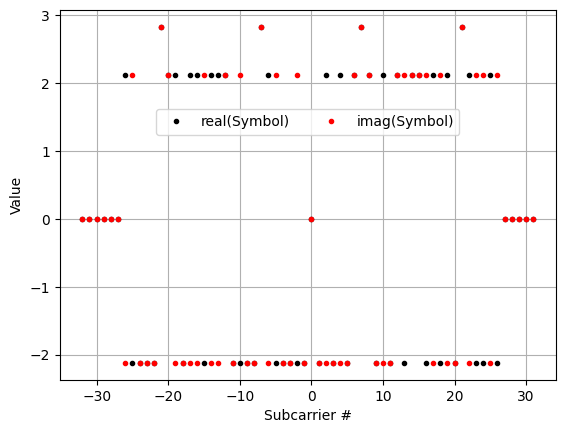

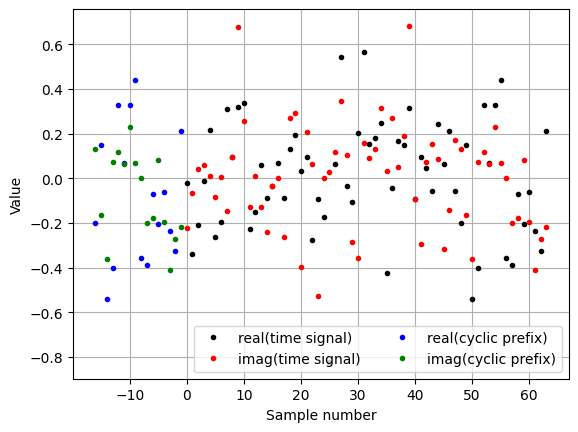

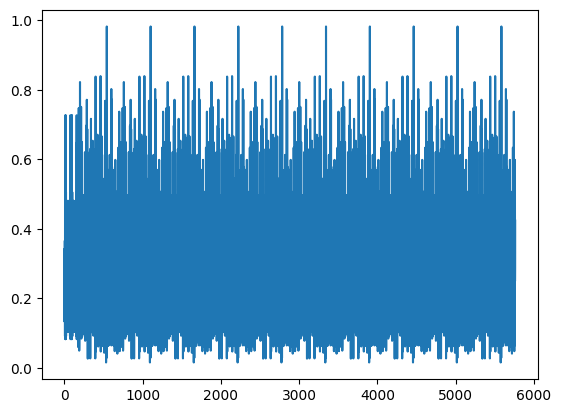

In [19]:
tx_signal = generate_ofdm_packet()
print('Length of tx_signal:',len(tx_signal))
print('Length of preamble:',len(generate_ltf()))

plt.figure()
plt.plot(abs(tx_signal))
plt.show()

In [20]:
IQ_filename = 'OFDM-packet' ### TODO ###

# Add the .iq extension and write the file.
IQ_filename_ext = IQ_filename + '.iq'
write_complex_binary(tx_signal, IQ_filename_ext)
print('IQ file generated')

IQ file generated


## 2. Over-the-air experiment on POWDER

🛑 If you are going to run an experiment on POWDER using Shout, this section provides the instructions to do so. The next code block here generates some of the command text you need. That code is used in accomplishing the following steps. You will end up with a receiver IQ file to upload back to colab.



1. Again, reference the table at the top for what nodes and frequency range to use based on your group number. You will be using the experiment you instantiated earlier for the remaining steps.

2. Move the iq file (in IQ_filename_ext) that you downloaded to your local CIR_lab working folder.

3. Edit the `save_iq_w_tx_file.json` file from the github repo. This file needs to be modified for your experiment. On your favorite text editor on your local computer, open and edit the JSON file:
  * Change `txfreq` and `rxfreq` to be at the center of your allocated frequency range
  * Change `txsamps` to specify your IQ file name (in `IQ_filename_ext`)
  * Change `txclients` and `rxclients` to have your designated nodes using the **ID** column in the experiment List View for the two client comp nodes. To reiterate, the "-comp" or "-dd-b210" end of the computer node name must be present in the strings.
  * If you are using B210 radios (i.e., using Dense Deployment nodes), change `txgain` and `rxgain` to be TX: 85, RX: 70. If you are using X310 radios (i.e, CBRS rooftop nodes), change `txgain` and `rxgain` to be TX: 27, RX: 30.

4. Open a terminal windows on your local computer: a) one on your local computer and use `cd` to move the working folder; b) two for the orchestrator; c) one for each client node.  The following code block can be used to create the text of these commands.

5. In both client terminal sessions, run uhd_usrp_probe to check the FPGA compatibility of the X310 it is connected to. (You don't need to do this for dense deployment nodes). If there is a version problem, run ./update_x310.sh, and power cycle the x310 on the experiment list view.

6. Copy the json and iq files to the orchestrator and clients using the scp commands that are generated below.

7. In one of the orchestrator terminal sessions, run: `./1.start_orch.sh`, and wait for it to finish.

8. In both client terminal sessions, run:
  * `./2.start_client.sh`
  * Wait for the two clients to say "Waiting for command..."

9. In the second orchestrator terminal session, run: `./3.run_cmd.sh`

10. After data collection finishes and the second orchestrator returns to the command prompt, run `cd /local/data`. There should be a Shout data folder labeled with the date and time you started the experiment.
  * scp the folder to your local computer using the command generated below.
  * Compress the Shout data folder and call it `data.zip`.: On the command line this is `zip -r data.zip <SHOUT_DATA_FOLDER>` where `<SHOUT_DATA_FOLDER>` is the name of the new data folder.
11. Navigate back to the folder icon in the left menu of this notebook. Upload `data.zip` by clicking the first icon (paper with up arrow). Run the code for the next two code cells to unzip the data you just collected and define the necessary cross-correlation functions.

In [23]:
# This code prints command-line commands you will use in the Shout experiment
# For convenience only.

### FILL IN these empty strings here ###
user_name = "npatwari"
orchnode_name = "pc11-fort"
clients = 2
clientnode_name = [[]]*clients   # Init an list of strings
clientnode_name[0] = "pc07-fort"
clientnode_name[1] = "pc06-fort"
# Add clientnode_names through clientnode_name[clients-1]
json_name = "save_iq_w_tx_file.json"
# The iq file name was already saved in `IQ_filename_ext`


# The rest of these commands print linux commands so that you can copy and paste them.
print("Create two terminal windows for the orchestrator compute node:")
print("ssh -Y -p 22 -t %s@%s.emulab.net 'cd /local/repository/bin && tmux new-session -A -s shout1 && exec $SHELL'"
      % (user_name, orchnode_name))
print("ssh -Y -p 22 -t %s@%s.emulab.net 'cd /local/repository/bin && tmux new-session -A -s shout2 && exec $SHELL'"
      % (user_name, orchnode_name))

print("Create one terminal windows for each client compute node:")
for i in range(clients):
    print("ssh -Y -p 22 -t %s@%s.emulab.net 'cd /local/repository/bin && tmux new-session -A -s shout && exec $SHELL'"
          % (user_name, clientnode_name[i]))

print()
print("Remember to check the firmware each SDR using: uhd_usrp_probe")

print()
print("Use *on your local computer* to copy json and iq files to each compute node:")
allnode_names = [orchnode_name] + clientnode_name
for compute_name in allnode_names:
    print("scp %s %s@%s.emulab.net:/local/repository/etc/cmdfiles/%s"
          % (json_name, user_name, compute_name, json_name))
for compute_name in allnode_names:
    print("scp %s %s@%s.emulab.net:/local/repository/shout/signal_library/%s"
          % (IQ_filename_ext, user_name, compute_name, IQ_filename_ext))

print()
print("After the experiment run, find the name of the folder that contains your results:")
print("ls /local/data/")
print("Copy that folder name to results_folder")

Create two terminal windows for the orchestrator compute node:
ssh -Y -p 22 -t npatwari@pc11-fort.emulab.net 'cd /local/repository/bin && tmux new-session -A -s shout1 && exec $SHELL'
ssh -Y -p 22 -t npatwari@pc11-fort.emulab.net 'cd /local/repository/bin && tmux new-session -A -s shout2 && exec $SHELL'
Create one terminal windows for each client compute node:
ssh -Y -p 22 -t npatwari@pc07-fort.emulab.net 'cd /local/repository/bin && tmux new-session -A -s shout && exec $SHELL'
ssh -Y -p 22 -t npatwari@pc06-fort.emulab.net 'cd /local/repository/bin && tmux new-session -A -s shout && exec $SHELL'

Remember to check the firmware each SDR using: uhd_usrp_probe

Use *on your local computer* to copy json and iq files to each compute node:
scp save_iq_w_tx_file.json npatwari@pc11-fort.emulab.net:/local/repository/etc/cmdfiles/save_iq_w_tx_file.json
scp save_iq_w_tx_file.json npatwari@pc07-fort.emulab.net:/local/repository/etc/cmdfiles/save_iq_w_tx_file.json
scp save_iq_w_tx_file.json npatwar

In [24]:
### TO DO: enter in the results folder name.
results_folder = ""   # eg, "Shout_meas_09-16-2025_18-41-32"

print("On your local computer terminal window, run:")
print("scp -r %s@%s.emulab.net:/local/data/%s ." % (user_name, orchnode_name, results_folder))

On your local computer terminal window, run:
scp -r npatwari@pc11-fort.emulab.net:/local/data/ .


## 3. OFDM Receiver

There are three options at this point for what complex baseband received signal sample vector to use:
1. Simulation: Add noise to the transmitted signal.
2. OTA Experiment: Send the transmitted signal over-the-air, receive it, and use the receiver file.
3. Load the rx signal from a previously conducted OTA experiment file.

For the in-class activity in WNS class, we will use the 3rd option.

In [12]:
# FOR THE SIMULATION OPTION ONLY
# Add random Gaussian noise to the transmitted signal.
# Choose your standard deviation sigma.

# rng = np.random.default_rng(seed=42)
# sigma = 0.1
# noise = sigma * rng.standard_normal(rx_signal.shape)
# rx_signal = tx_signal + noise

In [ ]:
# FOR THE OTA EXPERIMENT OPTION ONLY
#!unzip data.zip

🛑 A reminder to upload the '10dB_rx_output.dat' file. You can alternatively use the '15dB_rx_output.dat' to see an even cleaner signal, or the '5dB_rx_output.dat' to have more of a challenge.

In [52]:
# FOR THE LOAD PREVIOUSLY GENERATED FILE OPTION ONLY

## Load the received IQ file from file.
received_filename = '10dB_rx_output.dat' ### You can change this file.
rx_signal = np.fromfile(received_filename, dtype=np.complex64)

SyntaxError: invalid syntax (ipython-input-676517791.py, line 4)

The cross correlation in this notebook is implemented in a different, more computationally efficient manner than we did in the CIR Lab or the QPSK lab. In prior labs, we used numpy's `convolve` function, which does the convolution in the time domain. In the time domain, it is a sum of the product of the two signals just for one delay value. Thus this sum of the product must be calculated for each delay. In the frequency domain, the full convolution is computed with a single product. But for the frequency domain convolution method we need to add the computation of the Fourier transforms of both signals, and the inverse Fourier transform of the product. Still, the frequency domain method is faster for our case.

In [47]:
def cross_correlation_max(rx0, preamble, normalized=False, preamble_scale=0.001):
    """
    Cross-correlate rx0 with a known preamble and plot:
      - RX real/imag with the detected preamble overlaid at the detected start index
      - Correlation magnitude (or NCC) vs. sample index (no negative lags)
    """

    rx0 = np.asarray(rx0, dtype=np.complex64)
    preamble = np.asarray(preamble, dtype=np.complex64)

    # --- Complex matched filter correlation ---
    kernel = np.conj(preamble[::-1])
    xcorr_out = signal.fftconvolve(rx0, kernel, mode='valid')  # valid mode → only non-negative shifts

    # Optional - this normalizes the output so the energy of the output is not
    # artificially amplified. But we are just finding the max, so normalization
    # is not needed.
    if normalized:
        tpl_energy = np.sqrt(np.sum(np.abs(preamble)**2)) + 1e-12
        win_energy = np.sqrt(
            signal.convolve(np.abs(rx0)**2,
                            np.ones(len(preamble), dtype=np.float32),
                            mode='valid')
        ) + 1e-12
        metric = np.abs(xcorr_out) / (tpl_energy * win_energy)
        ylabel = "NCC value"
        title_suffix = " (Normalized)"
    else:
        metric = np.abs(xcorr_out)
        ylabel = "|Cross-correlation|"
        title_suffix = ""

    # Return the index of the peak of the correlation output.
    preamble_start = int(np.argmax(metric))

    print(f"Detected preamble at sample index {preamble_start}")

    # --- Plot the output so the user can validate that it is working ---
    fig, axes = plt.subplots(2, 1, figsize=(11, 6))

    # Top: RX signal with overlaid preamble
    axes[0].plot(np.real(rx0), label='Real RX Signal')
    axes[0].plot(np.imag(rx0), label='Imag RX Signal')
    overlay_x = np.arange(preamble_start, preamble_start + len(preamble))
    overlay_p = preamble * preamble_scale
    axes[0].plot(overlay_x, np.real(overlay_p), label='Preamble (real, scaled)')
    axes[0].plot(overlay_x, np.imag(overlay_p), label='Preamble (imag, scaled)', alpha=0.7)
    axes[0].set_title("Received Signal with Detected Preamble Overlay")
    axes[0].legend(loc='upper right')

    # Bottom: correlation metric vs. index
    axes[1].plot(metric, label=ylabel)
    axes[1].axvline(preamble_start, linestyle='--', color='r', label=f'Detected start = {preamble_start}')
    axes[1].set_xlabel("Sample index")
    axes[1].set_ylabel(ylabel)
    axes[1].legend(loc='upper right')
    axes[1].set_title(f"Cross-Correlation{title_suffix}")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return preamble_start


Some bit and symbol conversion functions; and our implementation of the symbol detector.

In [41]:
def binvector2str(bits):
    """
    Convert a flat iterable of 0/1 to a 7-bit ASCII string (MSB first).
    Pure-Python, no NumPy required.
    """
    bits = list(bits)
    if len(bits) % 7 != 0:
        raise ValueError("Length of bit stream must be a multiple of 7.")

    out_chars = []
    for i in range(0, len(bits), 7):
        byte = 0
        # MSB first: positions 0..6 map to weights 64..1
        # converts the binary chunk into its integer value
        for b in bits[i:i+7]:
            byte = (byte << 1) | (1 if b else 0)
        out_chars.append(chr(byte))
    # Joins the list of characters into a single string
    rx_text = ''.join(out_chars)
    print('Received Message:', rx_text)
    return rx_text

def mary2binary(data, M):
    length = len(data) # number of values in data
    log2M = round(np.log2(M)) # integer number of bits per data value
    format_string = '0' + str(log2M) + 'b'
    binarydata = np.zeros((1,length*log2M))
    count = 0
    for each in data:
        binval = format(int(each), format_string)
        for i in range(log2M):
            binarydata[0][count+i] = int(binval[i])
        count = count + log2M
    return binarydata

def findClosestComplex(r_hat, outputVec):
    # outputVec is a 4-length vector for QPSK, would be M for M-QAM or M-PSK.
    # This checks, one symbol sample at a time,  which complex symbol value
    # is closest in the complex plane.
    data_out = [np.argmin(np.abs(r-outputVec)) for r in r_hat]
    return data_out

def constellation_plot(signal):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.set_aspect(1.0)
    plt.plot(np.real(signal), np.imag(signal),'ro')
    plt.ylabel('Imag(Symbol Sample)', fontsize=14)
    plt.xlabel('Real(Symbol Sample)', fontsize=14)
    plt.title('Constellation Diagram')
    plt.grid('on')
    plt.tight_layout()


We can easily estimate the complex (magnitude, angle) gain that each pilot subcarrier gets multiplied by, because we know what the original complex amplitude that was sent in the pilot subcarrier (`pilotValue`). This code calls those pilot subcarrier gains as `Hp`. But full channel estimation requires interpolating between pilot subcarriers to estimate the complex (magnitude, angle) gain that every subcarrier gets multiplied by. This code calls that `H_full`.

In [48]:
def Channel_Estimation(signal):
    """
    Estimate the per-subcarrier channel H[k] for ONE OFDM symbol using pilots only.
    Strategy:
    """
    eps = 1e-12  # small number to prevent divide-by-zero / log(0)
    Yp = signal[pilotCarriers]

    # Xp: known transmitted pilot symbols.
    Xp = pilotValue if np.ndim(pilotValue) else np.full(len(pilotCarriers), pilotValue, dtype=complex)

    # Hp: channel estimate at pilot locations (divide received by known transmitted)
    Hp = Yp / (Xp + eps)

    # Split Hp into magnitude and phase for interpolation -
    mag_p = np.maximum(np.abs(Hp), eps)  # clamp to eps to avoid log(0)
    log_mag_p = np.log(mag_p)

    # Phase unwrap across pilot indices to avoid discontinuities at +/-pi boundaries.
    phase_p = np.unwrap(np.angle(Hp))

    # Interpolate (linear) from pilot bins to ALL ACTIVE subcarriers
    log_mag_all = np.interp(allCarriers, pilotCarriers, log_mag_p)
    phase_all   = np.interp(allCarriers, pilotCarriers, phase_p)

    # Recombine to complex H on active carriers
    H_estimate = np.exp(log_mag_all) * np.exp(1j * phase_all)

    # Pack into a full FFT-sized vector, leaving guards/DC as zeros
    H_full = np.zeros_like(signal, dtype=complex)
    H_full[allCarriers] = H_estimate

    return H_full

This is now the main code which calls the above functions.
- Note that in the saved `.dat` receiver files, the files are from real-time experiments on POWDER which start recording the `.dat` file when it finds the start of a packet. So when reading .dat files we *expect* to see a `preamble_start` index of 0.

Detected preamble at sample index 0


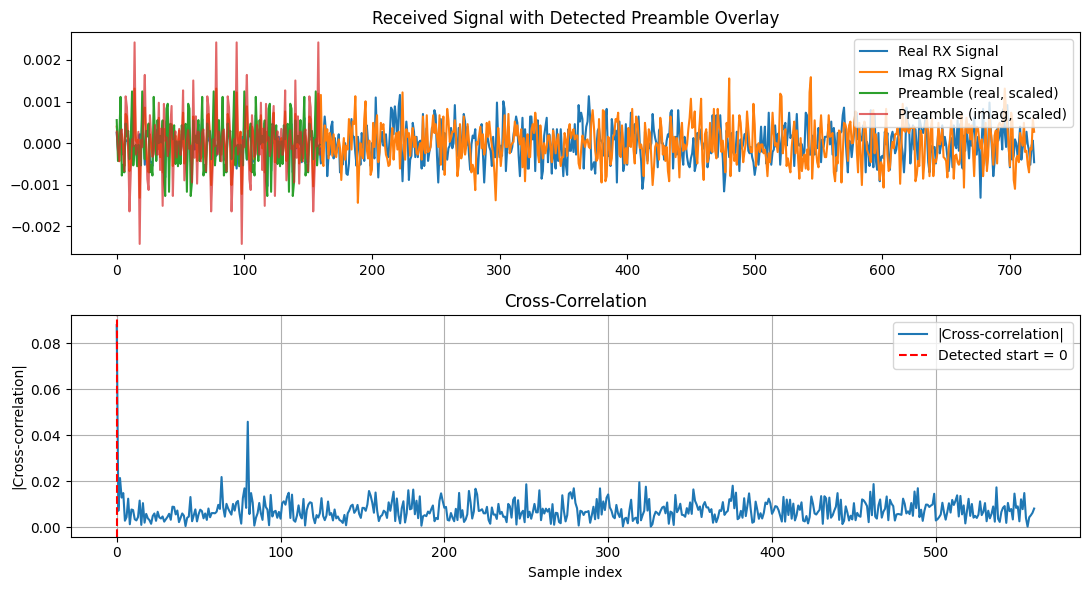

Preamble starts at index 0


In [49]:
## Load the packet preamble and cross-correlate it with the received signal.
preamble = generate_ltf()
preamble_start = cross_correlation_max(rx_signal,preamble)
print("Preamble starts at index", preamble_start)

Here is where the OFDM receiver operates, symbol by symbol. There is a for loop that operates on each `OFDM_size` samples until the packet is done.

🛑 You will implement:
1. Cyclic prefix removal
2. Computation of the FFT to convert the time-domain signal back into the frequency domain.
3. Using an estimate of the channel gain coefficients (estimated using the pilot subchannels), you will implement the equalization.

You may need to debug your code, so feel free to add print statements or plots. You should probably though put then in an `if i==0:` block so that they don't print out for all symbols.

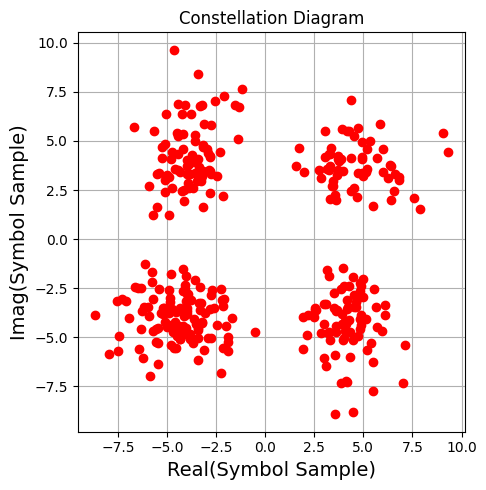

In [50]:
# Calculate the start index of the DATA part of the packet. Then copy `mess_length`
# samples, starting from that start index, into `data_signal`.
data_start = preamble_start + len(preamble)
data_signal = rx_signal[data_start: data_start + mess_length]

# Process each symbol (which is `OFDM_size` samples).
# Remember `OFDM_size` is the total symbol length including the part that will
# have an FFT taken, and the cyclic prefix which will be dropped.
for i in range(len(data_signal)//(OFDM_size)):
    data_cp = data_signal[i*(OFDM_size):(i+1)*(OFDM_size)]

    # Remove from data_cp the cyclic prefix, which is the first `CP` samples.
    # Call the output `data_without_cp`.

    ## YOUR CODE HERE ##

    # Take the FFT using np.fft.fft() on the non-CP symbol samples `data_without_cp`.
    # Remember the FFT is length `FFT_size`.
    # Call the output `OFDM_freq`.

    ## YOUR CODE HERE ##

    # Estimate the complex channel gain coefficients, using the pilot subcarriers.
    H_est = Channel_Estimation(OFDM_freq) # estimate the channel

    # Then equalize -- counteract each subcarrier's channel gain effect on OFDM_freq by
    # dividing it by its estimated channel gain in H_est.
    # Both are vectors and division is element-wise. Call the output `OFDM_est`.

    ## YOUR CODE HERE ##

    # The output, at the `dataCarriers` indices are the QPSK symbol values
    # Concatenate them across all OFDM symbols
    OFDM_data = OFDM_est[dataCarriers] # extract the data signal
    if i == 0:
        OFDM_swap =  OFDM_data
    else:
        OFDM_signal = np.concatenate((OFDM_swap,  OFDM_data))
        OFDM_swap = OFDM_signal

# We put QPSK on all subcarriers, so we can merge the constellation plot for all
# received QPSK symbol values, and plot it.
constellation_plot(OFDM_signal)

Finish by running a symbol detector, converting the m-ary symbols to bits, and then converting the bits to a text message. This code prints out the received string.

In [51]:
# Find the data bits corresponding to these complex symbol values, using the
# 4 possible QPSK symbols
outputVec = np.array([1+1j, -1+1j, 1-1j, -1-1j])
mary_out  = findClosestComplex(OFDM_signal, outputVec)
data_bits  = mary2binary(mary_out, 4)[0]


# Convert the output bits to a character string.
rx_message = binvector2str(data_bits)

Received Message: Pseudonymetry: A new spectrum sharing protocol for cooperative coexistence b/n wireless systems.


🛑  Answer these two questions:
 1. Compute the spectral efficiency, defined as the bit rate (in bits per second) divided by the bandwidth (here, 2 MHz). Note the sampling rate is also 2 MHz, so you can calculate the packet duration.
 2. What is most surprising to you about the OFDM receiver implementation?


YOUR ANSWER HERE.

🛑 Turn in this notebook on Canvas as a .ipynb file or print to a pdf.